In [151]:
import sys
sys.path.append(r'D:\python\finace')
from libs import MyEngine
import pandas as pd
import seaborn as sns
#coding:utf-8
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

# 因子选股：
- 交易量前一百与收益

In [152]:
sql = 'select stock_code, date, volume, open_price, close_price, turnover from stock_zh_a_hist_daily where date between "2024-07-20" and "2024-08-20"'
one_month_data = MyEngine().read_sql_query(sql)

In [153]:
one_month_data['earning_rate_now_day'] = (one_month_data['close_price']-one_month_data['open_price'])/one_month_data['open_price'] * 100
one_month_data['earning_rate_next_day'] = one_month_data['earning_rate_now_day'].shift(-1)
plot_df = []

for date, dfg in one_month_data.groupby(['date']):
    dfg.sort_values(by=['volume'], inplace=True, ascending=False)
    temp = dfg.iloc[:100, :]
    if isinstance(plot_df, list):
        plot_df = temp 
    else:
        plot_df = pd.concat([plot_df, temp])

<Axes: title={'center': '当日收益率 vs 上日成交金额（TOP 100）'}, xlabel='turnover', ylabel='earning_rate_next_day'>

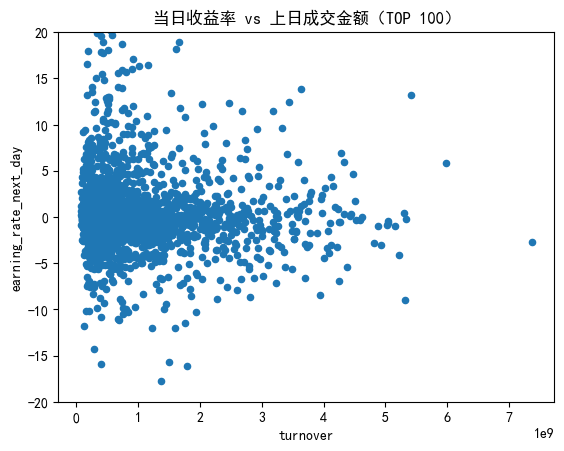

In [154]:
plot_df.plot(x='turnover', y='earning_rate_next_day', kind='scatter', title='当日收益率 vs 上日成交金额（TOP 100）',
             ylim=(-20, 20))

<Axes: title={'center': '当日收益率 vs 成交金额（TOP 100）'}, xlabel='turnover', ylabel='earning_rate_now_day'>

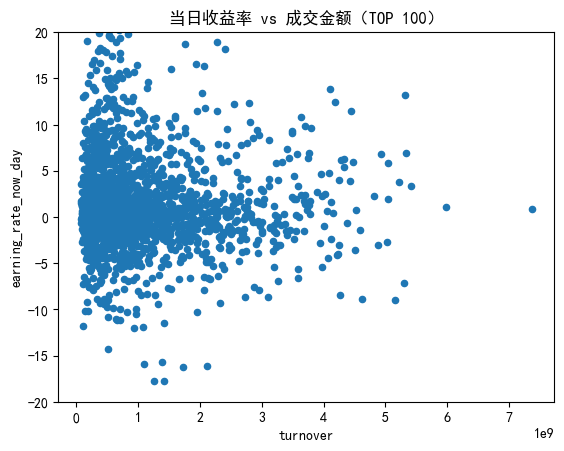

In [155]:
plot_df.plot(x='turnover', y='earning_rate_now_day', kind='scatter', title='当日收益率 vs 成交金额（TOP 100）',
             ylim=(-20, 20))

# 因子选股
- 一个月内，总计n次成交量、金额前100股票，收益率分析

In [156]:
sql2 = 'select stock_code, date, volume, open_price, close_price, turnover, price_change_percentage from stock_zh_a_hist_daily where date between "2024-08-21" and "2024-08-24"'
three_days_data = MyEngine().read_sql_query(sql2)

n = 10
plot_df.loc[:, 'num_first_100'] = plot_df.groupby(['stock_code'])['stock_code'].transform(lambda x: x.shape[0])
target_code = plot_df[plot_df['num_first_100']>n]['stock_code'].unique().tolist()
print(f'共计：{len(target_code)}')
target_data = three_days_data[three_days_data['stock_code'].isin(target_code)]


共计：80


<Axes: title={'center': '一个月内，总计20次以上金额前100股票，收益率分析'}, xlabel='stock_code'>

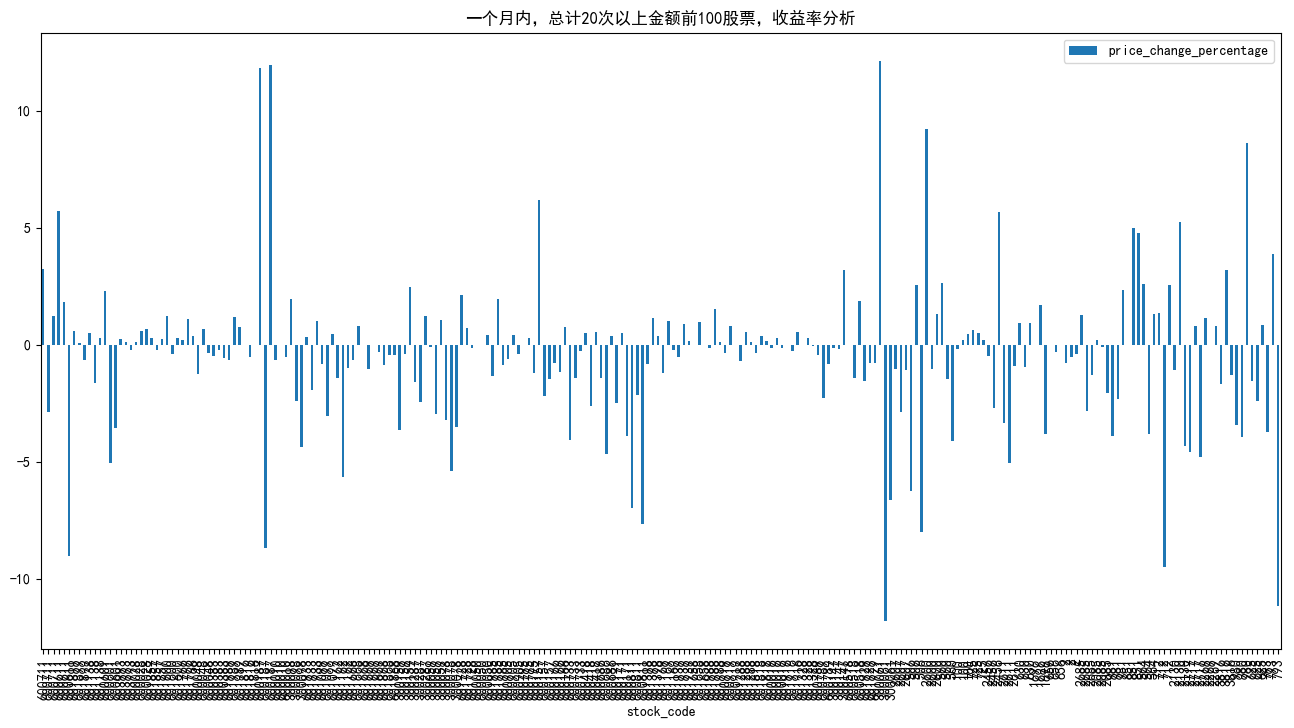

In [157]:
target_data.plot(x='stock_code', y='price_change_percentage', kind='bar', 
                 title='一个月内，总计20次以上金额前100股票，收益率分析',
                 figsize=(16, 8))

模型选股
- demo code: （20天历史数据输入，后5天累计收益率）

In [158]:
sql3 = 'select stock_code, date, open_price, close_price from stock_zh_a_hist_daily where date between "2024-01-01" and "2024-08-24"'
predicts = MyEngine().read_sql_query(sql3)

In [159]:
sql3 = 'select stock_code, date, open_price, close_price from stock_zh_a_hist_daily where date between "2024-01-01" and "2024-08-24"'
predicts = MyEngine().read_sql_query(sql3)
predicts.sort_values(by=['date'], inplace=True)
def func_(x):
    return x.iloc[-1]
predicts = predicts[predicts['stock_code'].isin(target_code)]
predicts['close_price_next_5'] = predicts.groupby(['stock_code'])['close_price'].transform(lambda x: x.rolling(5).apply(func_))
predicts['cum_sum_5'] = (predicts['close_price_next_5'] - predicts['open_price']) / predicts['open_price'] * 100

26527    2499.25
26528    2496.63
26529    2470.45
26530    2478.30
26531    2456.05
dtype: float64
26528    2496.63
26529    2470.45
26530    2478.30
26531    2456.05
26532    2463.90
dtype: float64
26529    2470.45
26530    2478.30
26531    2456.05
26532    2463.90
26533    2445.57
dtype: float64
26530    2478.30
26531    2456.05
26532    2463.90
26533    2445.57
26534    2448.19
dtype: float64
26531    2456.05
26532    2463.90
26533    2445.57
26534    2448.19
26535    2440.34
dtype: float64
26532    2463.90
26533    2445.57
26534    2448.19
26535    2440.34
26536    2441.65
dtype: float64
26533    2445.57
26534    2448.19
26535    2440.34
26536    2441.65
26537    2428.56
dtype: float64
26534    2448.19
26535    2440.34
26536    2441.65
26537    2428.56
26538    2393.21
dtype: float64
26535    2440.34
26536    2441.65
26537    2428.56
26538    2393.21
26539    2401.06
dtype: float64
26536    2441.65
26537    2428.56
26538    2393.21
26539    2401.06
26540    2402.37
dtype: float64


- 数据处理

In [171]:
sql4 = 'select stock_code, date, open_price, close_price, volume, turnover, amplitude, price_change_percentage, price_change_amount, turnover_rate  from stock_zh_a_hist_daily where date between "2024-01-01" and "2024-08-24" and stock_code in '
for i, code in enumerate(target_code):
    if i == (len(target_code)-1):
        sql4 = sql4 + str(code) + ')'
    elif i == 0:
        sql4 = sql4 + '(' + str(code) + ', '
    else:
        sql4 = sql4 + str(code) + ', '
inputs1 = MyEngine().read_sql_query(sql4)

sql5 = 'select stock_code, date, market_capitalization, earnings_ratio_ttm, earnings_ratio_static, book_ratio, cash_flow_ratio from stock_zh_valuation_baidu where date between "2024-01-01" and "2024-08-24" and stock_code in '
for i, code in enumerate(target_code):
    if i == (len(target_code)-1):
        sql5 = sql5 + str(code) + ')'
    elif i == 0:
        sql5 = sql5 + '(' + str(code) + ', '
    else:
        sql5 = sql5 + str(code) + ', '
inputs2 = MyEngine().read_sql_query(sql5)

sql6 = 'select 板块名称 as industry_name, 代码 as stock_code from industry_cons_em_details'
inputs3 = MyEngine().read_sql_query(sql6)

In [161]:
inputs1.loc[:, 'date_seconds'] = pd.to_datetime(inputs1['date']).astype('int64')//1e9
inputs1['price_change_percentage_next_day'] = inputs1['price_change_percentage'].shift(-1)
inputs1.dropna(inplace=True)
data1 = inputs1.drop(columns=['date'])
earnings = data1['price_change_percentage_next_day']
data1.drop(columns=['price_change_percentage_next_day'], inplace=True)

data2 = pd.merge(inputs2, inputs3, on='stock_code', how='left')
data2 = data2.groupby('stock_code').apply(lambda x: x.set_index('date').asfreq('D').reset_index().fillna(method='ffill'))
industry_map = inputs3['industry_name'].drop_duplicates().reset_index().drop('index', axis=1).reset_index().set_index('industry_name').to_dict()['index']
data2.loc[:, 'industry_name'] = data2['industry_name'].apply(lambda x: industry_map[x])
data2.loc[:, 'date_seconds'] = pd.to_datetime(data2['date']).astype('int64')//1e9
data2.drop(columns=['date'], inplace=True)
data2.reset_index(inplace=True, drop=True)
cols = data2.columns
temp = pd.merge(data1, data2, on=['stock_code', 'date_seconds'], how='left')
data2 = temp.fillna(method='ffill').fillna(method='bfill')[cols]
data2 = data2[data2['date_seconds'].isin(data1.date_seconds)]

assert data1.shape[0] == data2.shape[0]

- 输入shape:(days, 30, ) 价格，行业板块，市值数据
- 股票类别编码
- 日期编码

In [162]:
import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
import numpy as np


# 构建PyTorch数据集
class TimeSeriesDataset(data.Dataset):
    def __init__(self, data1, data2, earnings, window=40, stride=5):
        self.window = window
        self.stride = stride
        data, labels = self.__init_data__(data1, data2, earnings)
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).float()

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)
    
    def __init_data__(self, data1, data2, earnings):
        # 构建数据集
        data1_res = []
        data2_res= []
        labels_res = []
        for i in range(0, len(data1) - self.window, self.stride):
            data1_res.append(data1[i:i+self.window])
            data2_res.append(data2[i:i+self.window])
            labels_res.append(earnings[i+self.window-1])
        data1_res = np.array(data1_res)
        data2_res = np.array(data2_res)
        labels_res = np.array(labels_res)

        # 进行z score归一化
        scaler1 = StandardScaler()
        scaler2 = StandardScaler()
        data1_scaled = scaler1.fit_transform(data1_res.reshape(-1, data1.shape[1])).reshape(-1, self.window, data1.shape[1])
        data2_scaled = scaler2.fit_transform(data2_res.reshape(-1, data2.shape[1])).reshape(-1, self.window, data2.shape[1])
        data = np.concatenate((data1_scaled, data2_scaled), axis=2)
        return np.swapaxes(data, 1, 2), labels_res.reshape(-1, 1)

dataset = TimeSeriesDataset(data1.values, data2.values, earnings.values, window=40, stride=1)
# Initialize the dataset and data loader
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = data.random_split(dataset, [train_size, test_size])

# 构建数据加载器
batch_size = 32
train_data_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for batch in train_data_loader:
    print(batch[0].shape, batch[1].shape)

torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size([32, 18, 40]) torch.Size([32, 1])
torch.Size

In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the CNN+RNN model
class CNN_RNN(nn.Module):
    def __init__(self):
        super(CNN_RNN, self).__init__()
        self.conv1 = nn.Conv1d(18, 32, kernel_size=3)
        self.conv1_drop = nn.Dropout1d(p=0.5)  # 增加Dropout比例
        self.conv2 = nn.Conv1d(32, 32, kernel_size=3)
        self.batch_norm = nn.BatchNorm1d(32)  # 添加批量归一化层
        self.conv2_drop = nn.Dropout1d(p=0.5)  # 为第二个卷积层添加Dropout
        self.rnn = nn.GRU(32, 64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = nn.functional.relu(self.batch_norm(self.conv1(x)))  # 应用批量归一化
        x = nn.functional.relu(nn.functional.max_pool1d(self.conv1_drop(x), 2))
        x = self.batch_norm(self.conv2(x))  # 应用批量归一化
        x = nn.functional.relu(nn.functional.max_pool1d(self.conv2_drop(x), 2))
        x = x.view(-1, 8, 32)  # 确保这里的形状与max pooling的结果一致
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x



# Initialize the model, optimizer, and loss function
model = CNN_RNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

Epoch 1, Train Loss: 2.1515913009643555, Test Loss: 2.0994268301167067
Epoch 2, Train Loss: 1.7231837511062622, Test Loss: 2.0674890543841107
Epoch 3, Train Loss: 3.311476230621338, Test Loss: 2.0411478612996357
Epoch 4, Train Loss: 2.220656394958496, Test Loss: 2.0216321326509306
Epoch 5, Train Loss: 2.4607038497924805, Test Loss: 2.004970713506771
Epoch 6, Train Loss: 1.290102243423462, Test Loss: 2.0061378614811956
Epoch 7, Train Loss: 1.920907735824585, Test Loss: 1.9827688524994669
Epoch 8, Train Loss: 2.7295196056365967, Test Loss: 1.9771366511719137
Epoch 9, Train Loss: 2.0641748905181885, Test Loss: 1.9500518660002117
Epoch 10, Train Loss: 1.1715443134307861, Test Loss: 1.9672884156432333
Epoch 11, Train Loss: 2.7162866592407227, Test Loss: 1.9793968668466881
Epoch 12, Train Loss: 1.604514241218567, Test Loss: 1.9397253537479835
Epoch 13, Train Loss: 2.501189947128296, Test Loss: 1.9532286758664288
Epoch 14, Train Loss: 1.4131052494049072, Test Loss: 1.9410296467286121
Epoch 15

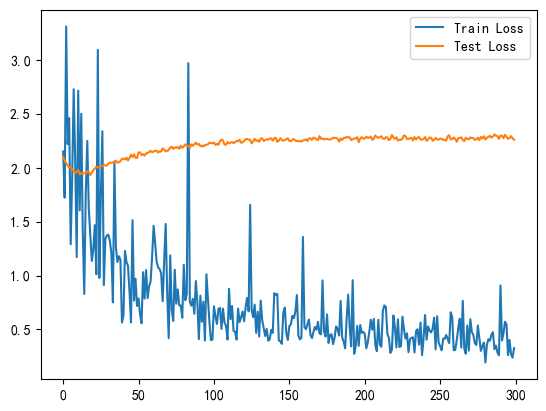

Best Epoch: 19, Best Test Loss: 1.9342618260202529


In [164]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Train the model
train_losses = []
test_losses = []
best_loss = float('inf')
best_epoch = 0
for epoch in range(300):
    for batch in train_data_loader:
        data, labels = batch
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_loss = loss.item()
    train_losses.append(train_loss)
    
    # 测试模型
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_data_loader:
            data, labels = batch
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_loss /= len(test_data_loader)
    test_losses.append(test_loss)
    
    # 保存最优模型
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

# 绘制训练推理误差曲线
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

print(f'Best Epoch: {best_epoch+1}, Best Test Loss: {best_loss}')

d:\python\py38\lib\site-packages\pandas\plotting\_matplotlib\core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

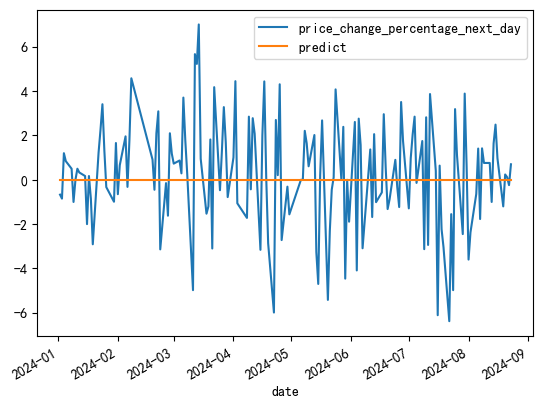

In [174]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            data, _ = batch
            outputs = model(data)
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
    return predictions
import torch.utils.data as data

inputs1.loc[:, 'date_seconds'] = pd.to_datetime(inputs1['date']).astype('int64')//1e9
inputs1['price_change_percentage_next_day'] = inputs1['price_change_percentage'].shift(-1)
inputs1.dropna(inplace=True)
data1 = inputs1.drop(columns=['date'])
earnings = data1['price_change_percentage_next_day']
data3 = data1.drop(columns=['price_change_percentage_next_day'])

data2 = pd.merge(inputs2, inputs3, on='stock_code', how='left')
data2 = data2.groupby('stock_code').apply(lambda x: x.set_index('date').asfreq('D').reset_index().fillna(method='ffill'))
industry_map = inputs3['industry_name'].drop_duplicates().reset_index().drop('index', axis=1).reset_index().set_index('industry_name').to_dict()['index']
data2.loc[:, 'industry_name'] = data2['industry_name'].apply(lambda x: industry_map[x])
data2.loc[:, 'date_seconds'] = pd.to_datetime(data2['date']).astype('int64')//1e9
data2.drop(columns=['date'], inplace=True)
data2.reset_index(inplace=True, drop=True)
cols = data2.columns
temp = pd.merge(data1, data2, on=['stock_code', 'date_seconds'], how='left')
data2 = temp.fillna(method='ffill').fillna(method='bfill')[cols]
data2 = data2[data2['date_seconds'].isin(data1.date_seconds)]

data1.sort_values(by=['stock_code', 'date_seconds'], inplace=True)
data1['date'] = pd.to_datetime(data1['date_seconds'], unit='s')

# earnings = data1['price_change_percentage_next_day']
dataset = TimeSeriesDataset(data3.values, data2.values, earnings.values, window=40, stride=1)
# 构建数据加载器
batch_size = 32
data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
data1['predict'] = pd.Series(predict(model, data_loader))

for code, df in data1.groupby('stock_code'):
    plt.clf()
    ax = df.plot(x='date', y='price_change_percentage_next_day', kind='line')
    df.plot(x='date', y='predict', kind='line', ax=ax)
    plt.savefig(f'./figs/{code}.png')
    plt.close()


In [1]:
outputs

NameError: name 'outputs' is not defined